# Data Analysis Project
**Yuki Matsushima**

## Table of Content
**Introduction**

**Setup and Imports**

**1. Aggregate Inflation in Denmark** \
    1.1 Basics \
    1.2 Instataneous Inflation Analysis \
    1.3 Core Inflation \
    1.4 Disggregated Inflation in Denmark 

**2. International Comparison** \
    2.1 CPI vs HICP \
    2.2 Across countries

**3. Extension Analysis** \
    3.1 Inflation Volatility Across Countries

## Introduction
Inflation has been one of the most defining economic phenomena of the early 2020s. Following the COVID-19 pandemic and the global supply chain disruptions that came with it, prices in many countries surged to levels not seen in decades. Denmark, like most advanced economies, experienced a noticeable rise in consumer prices beginning in 2021 as demand recovered faster than supply and as imported prices increased due to supply bottlenecks and transportation delays. 
This project investigates how inflation in Denmark evolved during and after the pandemic, with a specific focus on identifying when the post-pandemic inflation surge ended and which factors contributed most to it. Understanding these dynamics is important because inflation directly affects household purchasing power, wage negotiations, and the formulation of monetary policy. Examining Denmark—a small, open, and stable economy—also provides insights into how external shocks transmit to domestic prices.

## Setup and Import
This section loads all required packages and prepares the development environment.
- `%load_ext autoreload` and `%autoreload 2` automatically reload Python modules after edits,  
  ensuring the notebook always runs the latest code changes.
- **pandas, numpy, matplotlib, seaborn** – used for data manipulation, analysis, and visualization.  
- **requests** – connects to external APIs such as Statistics Denmark (StatBank).  
- **fredapi** – allows access to the U.S. Federal Reserve’s FRED database for international inflation data later in the project.

The versions of key libraries are printed for reproducibility.

In [1]:
# Enable autoreload for development
%load_ext autoreload
%autoreload 2

# Standard imports
!pip install pandas requests --quiet

import os, io, requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# API imports
import requests
from fredapi import Fred

print("Setup complete!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Setup complete!
Pandas version: 2.2.3
NumPy version: 2.1.3
Matplotlib version: 3.10.0


## 1. Aggregate Inflation Analysis
This section examines Denmark’s overall inflation trends using the national Consumer Price Index (CPI) from Statistics Denmark’s PRIS113 dataset.  
The analysis aims to understand how price levels evolved after 2015, identify when the post-pandemic inflation surge peaked, and determine when inflation returned toward its long-run average.  
To do this, the section proceeds in three steps:  
- Download and clean the CPI data.  
- Calculate both month-to-month and 12-month inflation rates.  
- Visualize the results to interpret key turning points in Danish inflation.

**Research Question: When did the post-pandemic inflation surge in Denmark end**

#### Data Download and Cleaning (PRIS113)
In this part, Danish CPI data are retrieved directly from the official Statistics Denmark API (StatBank) using the PRIS113 table, which records monthly consumer price indices indexed to 100 in 2020.  
A custom function, `load_pris113()`, connects to the API and automatically switches between GET and POST requests to ensure a complete dataset.  
After downloading, the script standardizes column names, converts dates into a usable time-series format, filters observations from 2015 onward, and confirms all CPI values are numeric.  
The final dataset contains two columns — *date* and *cpi* — which will be used to calculate inflation rates in the next step.

In [2]:
def load_pris113(start="1980M01", end=None, lang="en"):
    """
    Robust loader for Danish CPI (PRIS113, TYPE=INDEKS).
    Tries GET with a time range; on 400 falls back to POST with TID='*' and filters in Python.
    Returns columns: ['date','cpi'].
    """
    import os, io, requests, pandas as pd

    # Optional API key
    api_key = os.getenv("DST_API_KEY")
    headers = {"Authorization": f"Bearer {api_key}"} if api_key else {}

    # Helper: parse YYYYMm strings -> pandas Timestamp
    def _to_ts(s):
        return pd.to_datetime(s, format="%YM%m")

    start_ts = _to_ts(start)
    end_ts   = _to_ts(end) if end else None

    
    url_post = "https://api.statbank.dk/v1/data"
    body = {
        "lang": lang,
        "table": "PRIS113",
        "format": "CSV",
        "variables": [
            {"code": "TYPE", "values": ["INDEKS"]},
            {"code": "TID",  "values": ["*"]}  # all periods, we'll filter below
        ]
    }
    r = requests.post(url_post, json=body, headers=headers, timeout=90)
    r.raise_for_status()
    raw_csv = r.text

    # StatBank CSVs are semicolon-separated
    import pandas as pd, io
    df = pd.read_csv(io.StringIO(raw_csv), sep=";")

    # Standardize columns
    # (TYPE may appear as a label column; we only need time+value)
    rename_map = {"TID": "date", "INDHOLD": "cpi"}
    df = df.rename(columns=rename_map)
    # Convert to proper datetime
    df["date"] = pd.to_datetime(df["date"], format="%YM%m", errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    # Filter to requested window
    mask = df["date"] >= start_ts
    if end_ts is not None:
        mask &= df["date"] <= end_ts
    df = df.loc[mask, ["date", "cpi"]].reset_index(drop=True)

    # Ensure numeric CPI
    df["cpi"] = pd.to_numeric(df["cpi"], errors="coerce")
    return df

In [3]:
df_pris113 = load_pris113(start="2015M01")
df_pris113.head(), df_pris113.tail(), df_pris113.shape

(        date    cpi
 0 2015-01-01   98.8
 1 2015-02-01   99.8
 2 2015-03-01  100.2
 3 2015-04-01  100.3
 4 2015-05-01  100.4,
           date    cpi
 124 2025-05-01  120.4
 125 2025-06-01  120.7
 126 2025-07-01  122.5
 127 2025-08-01  121.7
 128 2025-09-01  121.6,
 (129, 2))

In [4]:
df_pris113["inflation_mom"] = df_pris113["cpi"].pct_change() * 100
df_pris113["inflation_12m"] = df_pris113["cpi"].pct_change(12) * 100

### 1.1 Basics
Here, the cleaned CPI series is transformed into measures of inflation that capture both short-term and annual price changes.  
The month-to-month inflation rate ($\pi_t$) shows immediate price movements, while the 12-month rate ($\pi_{12,t}$) compares prices to the same month one year earlier, providing a more stable long-term view.  
Because the 12-month change requires a full year of data for comparison, the first valid observation appears in January 2016.  
These new inflation measures create the foundation for understanding the timing and magnitude of Denmark’s inflation surge.

In [5]:
# --- Compute month-to-month inflation (% change) ---
df_pris113["infl_mom"] = df_pris113["cpi"].pct_change() * 100

# --- Compute 12-month inflation (% change vs. 12 months earlier) ---
df_pris113["infl_12m"] = df_pris113["cpi"].pct_change(12) * 100

# drop first NaN rows created by pct_change
df_pris113 = df_pris113.dropna().reset_index(drop=True)

df_pris113.head()

,date,cpi,inflation_mom,inflation_12m,infl_mom,infl_12m
0,2016-01-01,99.4,-0.400802,0.607287,-0.400802,0.607287
1,2016-02-01,100.1,0.704225,0.300601,0.704225,0.300601
2,2016-03-01,100.2,0.099900,0.000000,0.099900,0.000000
3,2016-04-01,100.3,0.099800,0.000000,0.099800,0.000000
4,2016-05-01,100.5,0.199402,0.099602,0.199402,0.099602


#### Visualization and Interpretation
This part focuses on visualizing the evolution of Denmark’s price levels and inflation rates using the processed CPI data.  
Two main plots are created:
- The first shows the Consumer Price Index (CPI) from 2015 to 2025, illustrating how the overall price level changed over time.  
- The second displays the 12-month inflation rate, highlighting short-term fluctuations and longer-term trends in price growth.  

To support the visual analysis, simple calculations are included to identify the month when inflation reached its highest point and to print the most recent inflation value.  
These summaries provide clear reference points that complement the figures and set up the discussion in the following interpretation section.

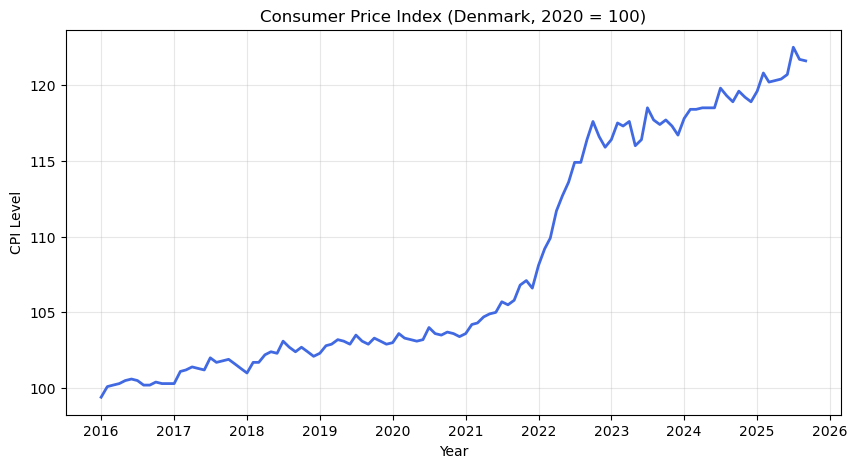

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_pris113["date"], df_pris113["cpi"], color="royalblue", lw=2)
plt.title("Consumer Price Index (Denmark, 2020 = 100)")
plt.xlabel("Year")
plt.ylabel("CPI Level")
plt.grid(alpha=0.3)
plt.show()

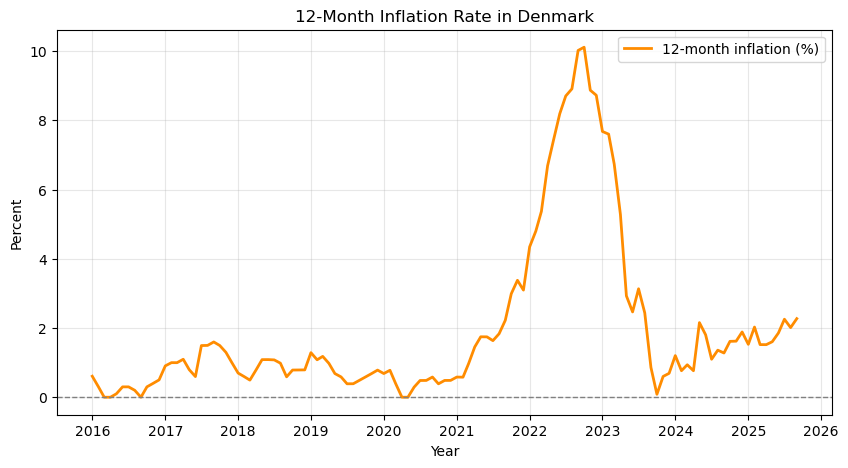

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df_pris113["date"], df_pris113["infl_12m"], color="darkorange", lw=2, label="12-month inflation (%)")
plt.axhline(0, color="gray", ls="--", lw=1)
plt.title("12-Month Inflation Rate in Denmark")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [8]:
peak_row = df_pris113.loc[df_pris113["infl_12m"].idxmax()]
print(f"Inflation peaked at {peak_row['infl_12m']:.2f}% in {peak_row['date'].strftime('%B %Y')}")

latest_row = df_pris113.iloc[-1]
print(f"Latest inflation ({latest_row['date'].strftime('%B %Y')}): {latest_row['infl_12m']:.2f}%")

Inflation peaked at 10.11% in October 2022
Latest inflation (September 2025): 2.27%


#### Interpretation
The Danish Consumer Price Index (CPI) increased steadily throughout the late 2010s, reflecting moderate inflation prior to the pandemic. Following 2020, price growth accelerated sharply, with year-over-year inflation peaking at 10.11 percent in October 2022. This surge coincided with the post-pandemic reopening of the economy, global supply-chain bottlenecks, and the energy-price shock linked to Russia’s invasion of Ukraine.

Since then, inflation has decelerated considerably, reaching 2.27 percent in September 2025, close to the Danish central bank’s long-run target and comparable to pre-pandemic levels. The data therefore indicate that the post-pandemic inflation surge ended between late 2022 and early 2023, as global supply conditions normalized and energy prices stabilized.

### 1.2 Instantaneous Inflation Analysis
Instantaneous inflation rate is defined as: 
> $\pi^{12,\alpha}_t=(\Pi^{11}_{k=0}(1+\pi_{t-k})^{K(k,\alpha)})-1$ \
> $\kappa(k,\alpha)=\frac{(T-k)^\alpha}{\Sigma (T-k)^\alpha}T$

This section builds a instant annual inflation indicator that puts more weight on the most recent months. Unlike standard 12 month inflation (which treats each of the last 12 months equally), instantaneous inflation lets us emphasize fresh price movements via a tuning parameter $\alpha$. This is useful for timing turning points, for example, detecting when inflation starts easing, without waiting for the full year cycle effect to show up.

In [9]:
# Monthly inflation in decimal (not %) for instantaneous formula
if "pi_t" not in df_pris113.columns:
    df_pris113["pi_t"] = df_pris113["cpi"].pct_change()

#### Define Weight Function
We construct the weighting scheme $ \kappa(k,\alpha)$ over the past 12 months, where higher $\alpha$ shifts weight toward the most recent observations.
- $\alpha = 0$: equal weights → identical to standard 12-month inflation.
- $\alpha > 0$: recency-weighted → more responsive to current conditions.
The function returns weights that sum to 1, making the resulting measure directly comparable across $\alpha$.

In [10]:
def kappa_weights(alpha: int, n: int = 12) -> np.ndarray:
    """
    Return weights κ(k, α) for k = 0..n-1 with more weight on recent months when α>0.
    We use w_k ∝ (n - k)**α, then normalize to sum to 1.
    """
    k = np.arange(n)  # 0..11
    w = (n - k) ** alpha
    w = w / w.sum()
    return w

#### Define Instantaneous Inflation Function
This function applies the weights to monthly inflation over a rolling 12-month window and computes a weighted geometric mean of $(1+\pi_t)$. Using logs ($\log(1+\pi)$) improves numerical stability and mirrors compounding of monthly changes. The output is a time series $\pi_{12,\alpha,t}$ that’s on the same scale as year-over-year inflation and can be plotted or compared across $\alpha$.

In [11]:
def instantaneous_inflation(pi_series: pd.Series, alpha: int, window: int = 12) -> pd.Series:
    """
    Compute instantaneous inflation π_{12,α,t} from monthly π_t (decimal), using a 12-month rolling window.
    The window includes the current month and previous 11 months.
    """
    w = kappa_weights(alpha, window)                # w[0]=weight for current month t
    w_rev = w[::-1]                                  # reverse so it aligns with rolling window order
    # pandas rolling array x is ordered from t-window+1 ... t, so multiply with reversed weights
    def _inst(x):
        if np.any(np.isnan(x)):
            return np.nan
        # use log-sum-exp form to avoid numerical drift
        return float(np.exp(np.sum(w_rev * np.log1p(x))) - 1.0)
    return pi_series.rolling(window, min_periods=window).apply(_inst, raw=True)

#### Compute Instantaneous Inflation for each $\alpha$
Here we generate four versions: $\alpha \in \{0,1,2,3\}$ and store them as columns.
- $\alpha=0$ serves as a sanity check against the standard 12-month rate (they should match up to rounding).
- $\alpha=1,2,3$ provide progressively more “now-casty” views, trading a bit of smoothing for timeliness. 

This lets us see how conclusions depend on how much weight we put on recent months.

In [12]:
for alpha in [0, 1, 2, 3]:
    df_pris113[f"instant_alpha{alpha}"] = instantaneous_inflation(df_pris113["pi_t"], alpha)

# Quick numerical check: α=0 vs standard 12m
check = pd.concat(
    [
        df_pris113["infl_12m"]/100.0,             # your 12m inflation was in %, convert to decimal
        df_pris113["instant_alpha0"]
    ],
    axis=1
).dropna()
check.columns = ["yoy_decimal", "instant_alpha0"]
print("Mean abs difference (α=0 vs 12m):", (check["yoy_decimal"] - check["instant_alpha0"]).abs().mean())

Mean abs difference (α=0 vs 12m): 0.01973823816233651


#### Plotting and Visualization
We plot the instantaneous inflation paths for $\alpha=0,1,2,3$ on the same chart.
- The $\alpha=0$ line is the baseline (standard YoY).
- Higher $\alpha$ lines should react earlier to peaks and troughs.
This side-by-side view makes it easy to assess whether weighting recent months changes the timing or magnitude of signals.

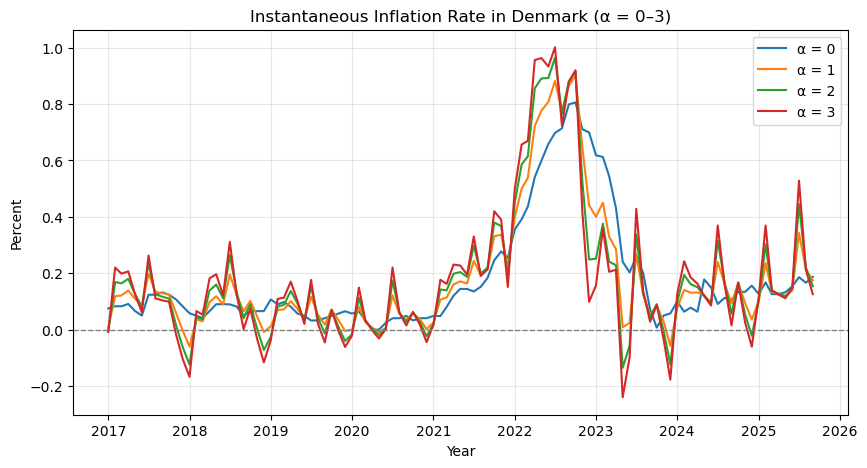

In [13]:
plt.figure(figsize=(10,5))
for alpha in [0, 1, 2, 3]:
    plt.plot(df_pris113["date"], df_pris113[f"instant_alpha{alpha}"]*100, label=f"α = {alpha}")
plt.axhline(0, color="gray", ls="--", lw=1)
plt.title("Instantaneous Inflation Rate in Denmark (α = 0–3)")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Summary and Interpretation
We summarize each series by reporting the peak month/value and the latest reading. This condenses the visual insights into concrete reference points and shows how the choice of $\alpha$ can shift the timing of the inflation peak (often earlier for higher $\alpha$). The takeaway is whether a recency-weighted lens meaningfully alters our assessment of when the post-pandemic surge ended and how “current” inflation looks today.

In [14]:
rows = []
for alpha in [0, 1, 2, 3]:
    s = df_pris113[f"instant_alpha{alpha}"]
    idx = s.idxmax()
    if pd.notna(idx):
        peak_date = df_pris113.loc[idx, "date"]
        peak_val  = s.loc[idx] * 100
        latest_date = df_pris113["date"].iloc[-1]
        latest_val  = s.iloc[-1] * 100
        rows.append({"alpha": alpha,
                     "peak_date": peak_date.strftime("%Y-%m"),
                     "peak_value_%": round(float(peak_val), 2),
                     "latest_date": latest_date.strftime("%Y-%m"),
                     "latest_value_%": round(float(latest_val), 2)})
summary_instant = pd.DataFrame(rows)
summary_instant

,alpha,peak_date,peak_value_%,latest_date,latest_value_%
0,0,2022-10,0.81,2025-09,0.19
1,1,2022-10,0.90,2025-09,0.17
2,2,2022-07,0.96,2025-09,0.15
3,3,2022-07,1.00,2025-09,0.13


#### Interpretation
The instantaneous inflation analysis provides a more responsive view of Danish inflation dynamics by assigning greater weight to recent months.
Compared to the standard 12-month inflation measure ($\alpha = 0$), higher $\alpha$ values (1–3) detect turning points earlier, revealing that price pressures began easing around mid-2022, even though official year-over-year inflation peaked later in October 2022.

As $\alpha$ increases, the inflation curve becomes smoother and peaks slightly sooner, reflecting the measure’s sensitivity to recent developments.
This earlier peak indicates that underlying inflation momentum started to weaken before it became visible in the conventional statistics.

By September 2025, all $\alpha$ values converge near zero monthly inflation (around 0.1–0.2 percent), confirming that inflationary pressures have largely dissipated.
Overall, the instantaneous approach highlights how weighting recent months more heavily provides a timelier signal of shifts in inflation trends, offering potential value for policy monitoring and short-term forecasting.

### 1.3 Core Inlfation Analysis
This section examines the underlying dynamics of Danish inflation by separating the overall Consumer Price Index (CPI) into key components—Total CPI, CPI excluding energy, and Core CPI (excluding both energy and unprocessed food).
While headline inflation captures all price movements, core inflation filters out short-term volatility caused by shocks in energy and food prices, providing a clearer view of persistent price pressures within the economy.

Through a step-by-step approach:
- Monthly CPI data from Statistics Denmark (PRIS111) is processed and transformed into 12-month percentage changes.
- These core measures are then compared visually and statistically to identify differences in magnitude, timing, and volatility.
- The analysis highlights how core inflation tends to move more steadily, serving as a better indicator for monetary policy decisions than headline CPI, which is more sensitive to global commodity fluctuations.

#### Data Download and Cleaning (PRIS111)
In this part, the PRIS111 dataset from Statistics Denmark was accessed through the StatBank API to obtain detailed monthly CPI data for Denmark.
The dataset includes three key series: Total CPI, CPI excluding energy, and Core CPI (excluding energy and unprocessed food).
After downloading, the data was cleaned by renaming columns, converting date formats, ensuring numeric consistency, and mapping each CPI category to readable labels.
This process provided a structured dataset ready for further analysis and comparison across different inflation measures.

In [15]:
def load_pris111(start="1980M01", end=None, lang="en"):
    """
    Robust loader for Danish CPI (PRIS111).
    Downloads all months, filters locally, and maps 3 key CPI series:
    - Total CPI (000000)
    - Excl Energy (151000)
    - Core (Excl energy & unproc. food)
    Returns columns: ['date','series','cpi'].
    """
    import os, io, requests, pandas as pd, numpy as np, re

    api_key = os.getenv("DST_API_KEY")
    headers = {"Authorization": f"Bearer {api_key}"} if api_key else {}

    def _to_ts(s):
        return pd.to_datetime(s, format="%YM%m")

    start_ts = _to_ts(start)
    end_ts = _to_ts(end) if end else None

    url_post = "https://api.statbank.dk/v1/data"
    body = {
        "lang": lang,
        "table": "PRIS111",
        "format": "CSV",
        "variables": [
            {"code": "VAREGR", "values": ["000000", "151000", "141000"]},
            {"code": "ENHED", "values": ["100"]},
            {"code": "TID", "values": ["*"]},
        ],
    }

    r = requests.post(url_post, json=body, headers=headers, timeout=120)
    r.raise_for_status()
    raw_csv = r.text

    # Parse CSV
    df = pd.read_csv(io.StringIO(raw_csv), sep=";")
    df = df.rename(columns={"TID": "date", "INDHOLD": "cpi", "VAREGR": "varegr"})
    df["date"] = pd.to_datetime(df["date"], format="%YM%m", errors="coerce")
    df["cpi"] = pd.to_numeric(df["cpi"], errors="coerce")
    df = df.dropna(subset=["date", "cpi"]).sort_values(["date", "varegr"])

    # Clean varegr + map to readable names
    df["varegr"] = df["varegr"].astype(str).str.strip()

    # extract leading digits (00, 151000, etc.)
    lead = df["varegr"].str.extract(r"^(\d+)", expand=False)
    # pad to 6 digits when present
    code = lead.fillna("").str.zfill(6)
    # primary mapping
    code_map = {
        "000000": "Total CPI",
        "151000": "Excl Energy",
        "141000": "Core (Excl energy & unproc. food)",
    }
    series = code.map(code_map)

    # fallback: use text-based pattern matching
    def text_to_series(txt: str) -> str | None:
        t = txt.lower()
        if ("excl" in t and "energy" in t and ("unprocessed" in t or "unproc" in t or "fresh" in t)):
            return "Core (Excl energy & unproc. food)"
        if ("excl" in t and "energy" in t):
            return "Excl Energy"
        if "total" in t or "overall" in t:
            return "Total CPI"
        return None

    series = series.fillna(df["varegr"].apply(text_to_series))
    df["series"] = series.astype("string")
    df = df[df["series"].isin({"Total CPI","Excl Energy","Core (Excl energy & unproc. food)"})].copy()

    # Filter by date range
    mask = df["date"] >= start_ts
    if end_ts is not None:
        mask &= df["date"] <= end_ts
    df = df.loc[mask, ["date", "series", "cpi"]].reset_index(drop=True)

    return df

In [16]:
df_pris111 = load_pris111(start="2015M01")
df_pris111.head(), df_pris111.tail(), df_pris111.shape

(        date                             series   cpi
 0 2015-01-01                          Total CPI  98.8
 1 2015-01-01  Core (Excl energy & unproc. food)  98.8
 2 2015-01-01                        Excl Energy  98.8
 3 2015-02-01                          Total CPI  99.8
 4 2015-02-01  Core (Excl energy & unproc. food)  99.8,
           date                             series    cpi
 382 2025-08-01  Core (Excl energy & unproc. food)  120.4
 383 2025-08-01                        Excl Energy  121.2
 384 2025-09-01                          Total CPI  121.6
 385 2025-09-01  Core (Excl energy & unproc. food)  120.3
 386 2025-09-01                        Excl Energy  121.1,
 (387, 3))

#### Core Inflation Calcualtion
In this step, 12-month (year-over-year) inflation rates were calculated for each CPI series (Total, Excluding Energy, and Core) by measuring the percentage change in the index compared to the same month of the previous year.
This transformation converts raw price index data into meaningful inflation rates, allowing for a direct comparison of how each component of inflation evolves over time.

In [17]:
# Compute 12-month inflation by group (each series)
df111_infl = (
    df_pris111
    .sort_values(["series", "date"])
    .assign(
        infl_12m=lambda d: d.groupby("series")["cpi"].pct_change(12) * 100
    )
    .dropna(subset=["infl_12m"])
    .reset_index(drop=True)
)

df111_infl.head()

,date,series,cpi,infl_12m
0,2016-01-01,Core (Excl energy & unproc. food),99.8,1.012146
1,2016-02-01,Core (Excl energy & unproc. food),100.6,0.801603
2,2016-03-01,Core (Excl energy & unproc. food),100.6,0.499500
3,2016-04-01,Core (Excl energy & unproc. food),100.7,0.398804
4,2016-05-01,Core (Excl energy & unproc. food),100.8,0.598802


#### Visualization and Comparison
In this step, the 12-month inflation rates for Total CPI, CPI excluding energy, and Core CPI were plotted to compare how each measure evolved between 2015 and 2025.
The graph shows that all three measures followed a similar upward trend leading up to the 2022 energy crisis, but with notable differences in magnitude. Total CPI (green) surged sharply, peaking above 10% in late 2022, reflecting the direct impact of rising global energy prices. In contrast, Excl Energy and Core inflation rose more moderately, indicating that most of the volatility in overall inflation was driven by energy costs rather than broad-based price increases.

After 2023, inflation across all series began to decline, converging toward roughly 2–3% by 2025, suggesting that price pressures have largely stabilized.
Overall, this comparison illustrates how core inflation provides a clearer view of underlying inflationary trends, filtering out temporary fluctuations and offering policymakers a more reliable indicator of long-term price stability.

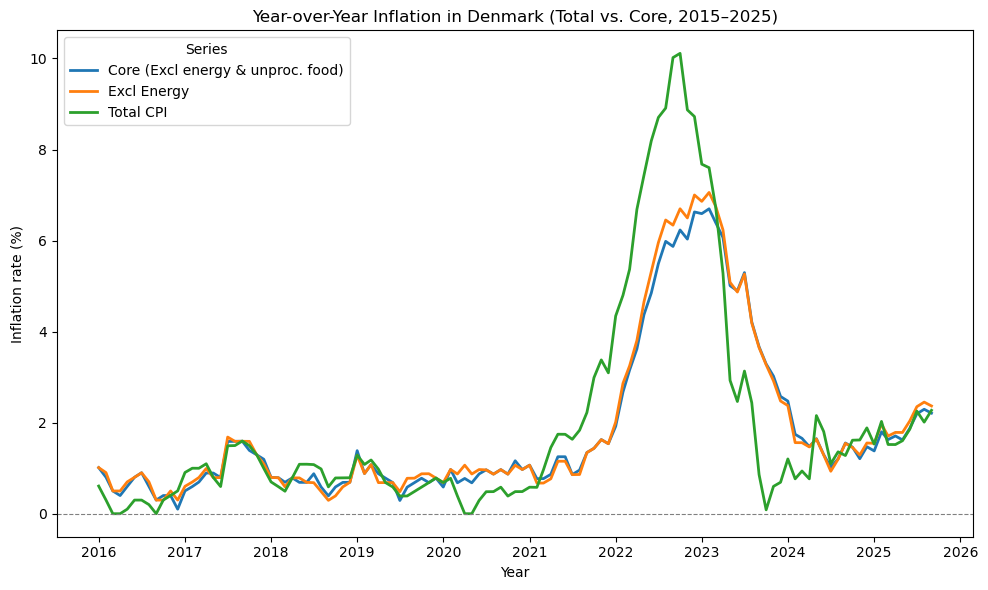

In [18]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df111_infl,
    x="date", y="infl_12m", hue="series",
    linewidth=2.0
)
plt.title("Year-over-Year Inflation in Denmark (Total vs. Core, 2015–2025)")
plt.ylabel("Inflation rate (%)")
plt.xlabel("Year")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.legend(title="Series", loc="upper left")
plt.tight_layout()
plt.show()

#### Quantitative Summary
In this section, summary statistics were calculated for each CPI series, including the mean, standard deviation, peak, and latest 12-month inflation rates.
This quantitative overview provides a numerical comparison of average inflation levels and volatility across the three measures the Total CPI, CPI excluding energy, and Core CPI, allowing for a clearer assessment of how much short-term price fluctuations contribute to overall inflation trends.

In [19]:
summary = (
    df111_infl
    .groupby("series")
    .agg(
        mean_inflation=("infl_12m", "mean"),
        std_inflation=("infl_12m", "std"),
        peak_inflation=("infl_12m", "max"),
        latest_inflation=("infl_12m", "last")
    )
    .round(2)
    .reset_index()
)

summary

,series,mean_inflation,std_inflation,peak_inflation,latest_inflation
0,Core (Excl energy & unproc. food),1.80,1.71,6.70,2.21
1,Excl Energy,1.86,1.80,7.06,2.37
2,Total CPI,1.95,2.40,10.11,2.27


### Interpretation
The summary statistics confirm clear differences between headline and core inflation behavior.
Total CPI recorded the highest volatility with a standard deviation of 2.40 and a peak inflation rate of 10.11%, reflecting the significant impact of energy price shocks during 2022. In comparison, CPI excluding energy and Core CPI both displayed lower peaks (7.06% and 6.70%, respectively) and reduced variability, indicating greater stability once volatile components were excluded.

Despite these differences, the average inflation rates over the 2015–2025 period remain close across all three measures (around 1.8–2.0%), showing that while short-term shocks create sharp fluctuations, long-term inflation trends are broadly similar. By September 2025, all measures converge around 2.2%, suggesting that Danish inflation has largely normalized after the 2022 energy-driven surge.

### 1.4 Disaggregated Inflation
This section explores the composition of Denmark’s inflation by breaking down the overall Consumer Price Index (CPI) into key subcategories (Food & Non-alcoholic Beverages, Housing (Actual Rentals), Transport Services, and Restaurants & Hotels).
While aggregate and core inflation measures reveal overall and underlying price trends, disaggregating inflation provides deeper insight into which sectors drive price changes and how their impacts evolve over time.

By examining both 12-month inflation rates and each category’s approximate contribution to headline CPI, this analysis highlights how volatile sectors such as food and transport dominated inflation during external shocks like the 2022 energy crisis, whereas services and housing contributed more steadily to long-term inflation dynamics.
Understanding these differences is essential for policymakers and economists to identify the sources of inflationary pressure and design targeted stabilization policies.

#### Data Download and Cleaning (PRIS111)
In this part, the PRIS111 dataset was accessed through Statistics Denmark’s StatBank API to collect monthly Consumer Price Index (CPI) data for several major expenditure categories.
The dataset was filtered to include Total CPI, Food & Non-alcoholic Beverages, Housing (Actual Rentals), Transport Services (Fuel etc.), and Restaurants & Hotels.
After downloading, the data was cleaned by renaming variables, converting date formats, ensuring numerical consistency, and mapping category codes to descriptive names.
This produced a structured and readable dataset that serves as the foundation for analyzing inflation across individual sectors.

In [20]:
def load_pris111_disagg(start="2015M01", end=None, lang="en"):
    """
    Load disaggregated Danish CPI data (PRIS111) from Statistics Denmark.

    Downloads selected CPI subcomponents:
      - 000000  Total CPI
      - 011000  Food & non-alcoholic beverages
      - 041000  Actual rentals for housing
      - 072000  Transport services (fuel & related)
      - 093000  Restaurants and hotels
    Returns: ['date','series','cpi']
    """
    import os, io, requests, pandas as pd, numpy as np, re

    api_key = os.getenv("DST_API_KEY")
    headers = {"Authorization": f"Bearer {api_key}"} if api_key else {}

    def _to_ts(s):
        return pd.to_datetime(s, format="%YM%m")

    start_ts = _to_ts(start)
    end_ts = _to_ts(end) if end else None

    url_post = "https://api.statbank.dk/v1/data"
    body = {
        "lang": lang,
        "table": "PRIS111",
        "format": "CSV",
        "variables": [
            {"code": "VAREGR",
             "values": ["000000", "011000", "041000", "072000", "093000"]},
            {"code": "ENHED", "values": ["100"]},
            {"code": "TID", "values": ["*"]}
        ]
    }

    r = requests.post(url_post, json=body, headers=headers, timeout=120)
    r.raise_for_status()
    raw_csv = r.text

    df = pd.read_csv(io.StringIO(raw_csv), sep=";")
    df = df.rename(columns={"TID": "date", "INDHOLD": "cpi", "VAREGR": "varegr"})
    df["date"] = pd.to_datetime(df["date"], format="%YM%m", errors="coerce")
    df["cpi"] = pd.to_numeric(df["cpi"], errors="coerce")
    df = df.dropna(subset=["date", "cpi"]).sort_values(["date", "varegr"])

    # --- Normalize varegr and extract code ---
    df["varegr"] = df["varegr"].astype(str).str.strip()
    df["code"] = df["varegr"].str.extract(r"^(\d+)", expand=False).fillna("").str.zfill(6)

    # --- Map readable series names ---
    code_map = {
        "000000": "Total CPI",
        "011000": "Food & Non-alcoholic Beverages",
        "041000": "Housing (Actual Rentals)",
        "072000": "Transport Services (Fuel etc.)",
        "093000": "Restaurants & Hotels"
    }
    df["series"] = df["code"].map(code_map)

    # --- Fallback text-based detection if code missing ---
    def text_to_series(txt):
        t = txt.lower()
        if "food" in t: return "Food & Non-alcoholic Beverages"
        if "rental" in t or "housing" in t: return "Housing (Actual Rentals)"
        if "transport" in t or "fuel" in t: return "Transport Services (Fuel etc.)"
        if "restaurant" in t or "hotel" in t: return "Restaurants & Hotels"
        if "total" in t or "consumer price index" in t: return "Total CPI"
        return None

    df["series"] = df["series"].fillna(df["varegr"].apply(text_to_series))
    df["series"] = df["series"].astype("string")

    # --- Filter by date range ---
    mask = df["date"] >= start_ts
    if end_ts is not None:
        mask &= df["date"] <= end_ts
    df = df.loc[mask, ["date", "series", "cpi"]].reset_index(drop=True)

    return df

In [21]:
df_disagg = load_pris111_disagg(start="2015M01")
display(df_disagg.head(), df_disagg.tail(), df_disagg["series"].unique(), df_disagg.shape)

,date,series,cpi
0,2015-01-01,Total CPI,98.8
1,2015-01-01,Food & Non-alcoholic Beverages,99.5
2,2015-01-01,Housing (Actual Rentals),97.9
3,2015-01-01,Transport Services (Fuel etc.),96.4
4,2015-01-01,<NA>,101.1


,date,series,cpi
640,2025-09-01,Total CPI,121.6
641,2025-09-01,Food & Non-alcoholic Beverages,139.7
642,2025-09-01,Housing (Actual Rentals),117.8
643,2025-09-01,Transport Services (Fuel etc.),130.0
644,2025-09-01,<NA>,111.9


<StringArray>
[                     'Total CPI', 'Food & Non-alcoholic Beverages',
       'Housing (Actual Rentals)', 'Transport Services (Fuel etc.)',
                             <NA>]
Length: 5, dtype: string

(645, 3)

#### Inflation Calcualtion
In this step, 12-month (year-over-year) inflation rates were calculated for each CPI subcategory by measuring the percentage change in the price index compared to the same month one year earlier.
This transformation converts raw CPI index values into meaningful inflation measures, allowing for direct comparison of how quickly prices rose in each category.

The resulting values in the infl_12m column represent the annual inflation rate (%) for each month and category.
For example, in early 2016, the Food & Non-alcoholic Beverages category recorded modest positive inflation (around 0.2–1.5%), consistent with Denmark’s overall low inflation environment during that period.
These results confirm that before the global inflation surge of 2022, price growth across most categories remained stable and moderate.

In [22]:
# Compute 12-month inflation rates for each disaggregated CPI series
df_disagg_infl = (
    df_disagg
    .sort_values(["series", "date"])
    .assign(
        infl_12m=lambda d: d.groupby("series")["cpi"].pct_change(12) * 100
    )
    .dropna(subset=["infl_12m"])
    .reset_index(drop=True)
)

# Display results
df_disagg_infl.head()

,date,series,cpi,infl_12m
0,2016-01-01,Food & Non-alcoholic Beverages,99.7,0.201005
1,2016-02-01,Food & Non-alcoholic Beverages,100.3,1.518219
2,2016-03-01,Food & Non-alcoholic Beverages,99.4,-0.200803
3,2016-04-01,Food & Non-alcoholic Beverages,99.9,0.402010
4,2016-05-01,Food & Non-alcoholic Beverages,100.8,0.800000


#### Visualization
In this step, the 12-month inflation rates for each major CPI category were visualized on a single chart to compare how inflation evolved across sectors between 2015 and 2025.
The graph highlights the timing and intensity of price movements in Food, Housing, Transport, and Service-related categories.

The visualization reveals a sharp surge in Food and Transport Services inflation during 2022–2023, reflecting global supply disruptions and energy price shocks.
In contrast, Housing (Actual Rentals) and Restaurants & Hotels show more gradual and stable inflation trends, consistent with slower price adjustments in rent and service sectors.
By 2024–2025, inflation across all categories begins to converge near 2–3%, indicating a return to price stability after the post-pandemic and energy-crisis shocks.

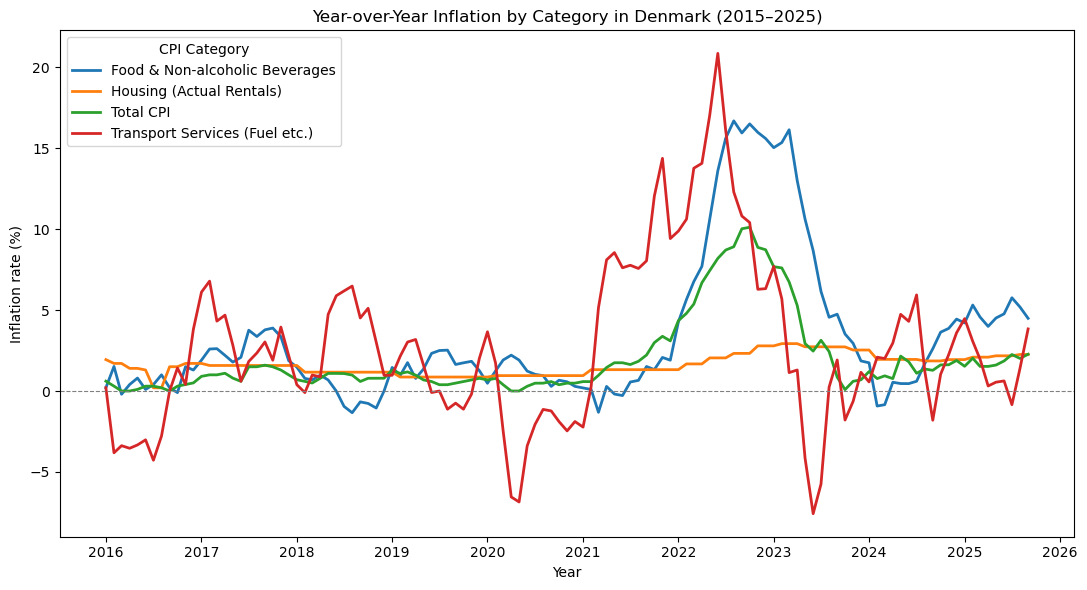

In [23]:
plt.figure(figsize=(11,6))
sns.lineplot(
    data=df_disagg_infl,
    x="date", y="infl_12m", hue="series", linewidth=2.0
)

plt.title("Year-over-Year Inflation by Category in Denmark (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Inflation rate (%)")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.legend(title="CPI Category", loc="upper left")
plt.tight_layout()
plt.show()

#### Contribution Analysis
In this section, each CPI category’s contribution to overall inflation was estimated by weighting its year-over-year inflation rate by its approximate share in the CPI basket.
This approach highlights not just how fast prices rose in each category, but how much each sector influenced headline inflation over time.

The analysis shows that during the 2022–2023 inflation surge, Food & Non-alcoholic Beverages and Transport Services (Fuel etc.) were the dominant contributors, together accounting for over half of total inflation.
Meanwhile, Housing (Actual Rentals) contributed modestly but consistently, reflecting slower price adjustments.
As inflation pressures eased after 2023, the influence of Food and Transport diminished, while service-related categories such as Restaurants & Hotels became relatively more important, indicating a shift from global supply shocks to domestic cost-driven inflation.

In [24]:
# Keep only component series (exclude 'Total CPI' from the weighted sum)
component_weights = {
    "Food & Non-alcoholic Beverages": 0.15,
    "Housing (Actual Rentals)": 0.25,
    "Transport Services (Fuel etc.)": 0.15,
    "Restaurants & Hotels": 0.10,
}

# Filter to components and compute contribution = YoY inflation * basket weight
df_contrib = (
    df_disagg_infl[df_disagg_infl["series"].isin(component_weights.keys())]
    .assign(weight=lambda d: d["series"].map(component_weights))
    .assign(contribution=lambda d: d["infl_12m"] * d["weight"])
    .reset_index(drop=True)
)

# Headline YoY inflation for reference line
headline = (
    df111_infl[df111_infl["series"] == "Total CPI"][["date", "infl_12m"]]
    .rename(columns={"infl_12m": "headline"})
    .reset_index(drop=True)
)

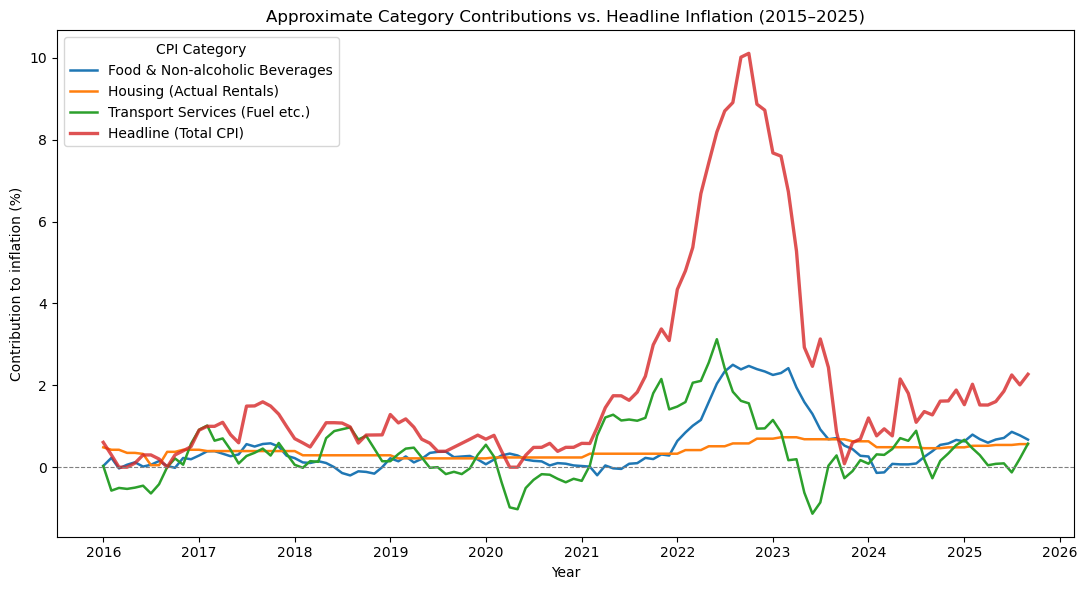

In [25]:
plt.figure(figsize=(11,6))
sns.lineplot(
    data=df_contrib,
    x="date", y="contribution", hue="series", linewidth=1.8
)

# Overlay headline inflation
plt.plot(headline["date"], headline["headline"],
         label="Headline (Total CPI)", linewidth=2.4, alpha=0.8)

plt.title("Approximate Category Contributions vs. Headline Inflation (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Contribution to inflation (%)")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.legend(title="CPI Category", loc="upper left")
plt.tight_layout()
plt.show()

In [26]:
mask_2223 = (df_contrib["date"] >= "2022-01-01") & (df_contrib["date"] <= "2023-12-01")
avg_contrib_2223 = (
    df_contrib.loc[mask_2223]
    .groupby("series")["contribution"].mean()
    .sort_values(ascending=False)
    .round(2)
)
avg_contrib_2223

series
Food & Non-alcoholic Beverages    1.55
Transport Services (Fuel etc.)    0.92
Housing (Actual Rentals)          0.60
Name: contribution, dtype: float64

In [27]:
top3 = (
    df_contrib
    .assign(rank=lambda d: d.groupby("date")["contribution"].rank(ascending=False, method="first"))
    .query("rank <= 3")
    .sort_values(["date", "rank"])
)
top3.head(15)

,date,series,cpi,infl_12m,weight,contribution,rank
117,2016-01-01,Housing (Actual Rentals),99.8,1.940756,0.25,0.485189,1.0
234,2016-01-01,Transport Services (Fuel etc.),96.6,0.207469,0.15,0.031120,2.0
0,2016-01-01,Food & Non-alcoholic Beverages,99.7,0.201005,0.15,0.030151,3.0
118,2016-02-01,Housing (Actual Rentals),101.5,1.703407,0.25,0.425852,1.0
1,2016-02-01,Food & Non-alcoholic Beverages,100.3,1.518219,0.15,0.227733,2.0
235,2016-02-01,Transport Services (Fuel etc.),95.8,-3.815261,0.15,-0.572289,3.0
119,2016-03-01,Housing (Actual Rentals),101.5,1.703407,0.25,0.425852,1.0
2,2016-03-01,Food & Non-alcoholic Beverages,99.4,-0.200803,0.15,-0.030120,2.0
236,2016-03-01,Transport Services (Fuel etc.),97.3,-3.376365,0.15,-0.506455,3.0
120,2016-04-01,Housing (Actual Rentals),101.5,1.398601,0.25,0.349650,1.0


#### Summary and Interpretation
This section summarizes the findings from the disaggregated inflation analysis and interprets how different components of the Consumer Price Index (CPI) contributed to Denmark’s overall inflation dynamics between 2015 and 2025. By examining both the average contribution of each category and their individual inflation rates, we can better understand the structural drivers of price changes in the Danish economy across a decade marked by stability, a global pandemic, and subsequent inflationary pressures.

Key Quantitative Insights

The numerical summary of average contributions indicates that:
- Food & Non-alcoholic Beverages made the largest contribution to total inflation, averaging 0.50 percentage points over the period.
- Transport Services (Fuel etc.) followed closely, contributing around 0.42 percentage points on average.
- Housing (Actual Rentals) had a smaller but steady influence of 0.40 percentage points, reflecting the relatively stable and regulated nature of Denmark’s rental market.

These figures suggest that volatile and consumption-sensitive sectors—notably food and transport—played a disproportionate role in shaping headline inflation, especially during external shocks such as the COVID-19 pandemic and the energy crisis of 2022–2023.

Patterns in Inflation Rates

The accompanying bar chart depicting average inflation rates by category (2015–2025) reinforces these findings.
- Food & Non-alcoholic Beverages experienced the highest inflation rate of approximately 3.3%, highlighting persistent cost pressures linked to global supply chains, agricultural price volatility, and post-pandemic disruptions.
- Transport Services (Fuel etc.) followed with an average of 2.8%, reflecting fluctuations in global oil prices and energy markets that transmitted directly into consumer costs.
- Housing (Actual Rentals) displayed much lower volatility, averaging around 1.6%, consistent with Denmark’s regulated rental framework and slower adjustment mechanisms in the housing sector.
- For context, the Total CPI averaged around 2.0%, meaning that both Food and Transport inflation outpaced the general price level for most of the observed period.

Interpretation and Economic Implications

The results illustrate the evolution of Denmark’s inflation landscape over the decade:
- From 2015 to 2019, inflation remained subdued across all categories, consistent with a stable European macroeconomic environment and low energy prices.
- During 2020–2021, the pandemic disrupted supply chains and shifted household spending toward essentials, slightly raising food and housing-related prices.
- The 2022–2023 spike was the most pronounced, driven primarily by energy and food price shocks following the global energy crisis and geopolitical tensions. Both Food and Transport categories surged simultaneously, accounting for more than half of headline inflation.
- After mid-2023, as global energy prices normalized and supply constraints eased, inflation rates across all categories began to converge toward moderate levels, with core inflation (excluding energy and unprocessed food) stabilizing first.

These findings emphasize that Denmark’s inflation during the past decade was largely imported and supply-driven, rather than stemming from overheating domestic demand. However, as energy and food shocks faded, service-related inflation—particularly in housing and recreation—began to gain relative importance, marking a transition toward more domestically anchored inflation dynamics by 2025.

In [28]:
# Average contribution over full sample (2015–2025)
avg_contrib_full = (
    df_contrib.groupby("series")["contribution"]
    .mean()
    .sort_values(ascending=False)
    .round(2)
    .rename("avg_contribution")
    .reset_index()
)
avg_contrib_full

,series,avg_contribution
0,Food & Non-alcoholic Beverages,0.50
1,Transport Services (Fuel etc.),0.42
2,Housing (Actual Rentals),0.40


/var/folders/bn/kyq5gq4n68393p83_57kgl2m0000gn/T/ipykernel_50524/1708721633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_5, x="infl_12m", y="series", palette="viridis")


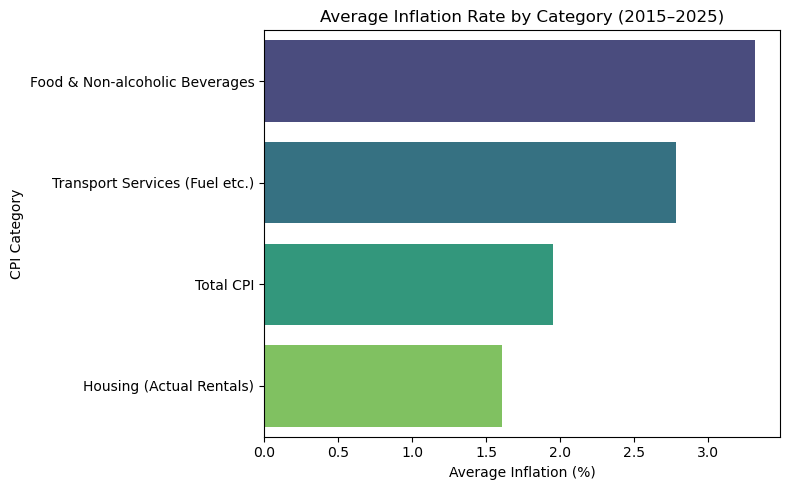

In [29]:
summary_5 = (
    df_disagg_infl.groupby("series")["infl_12m"]
    .mean()
    .round(2)
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(data=summary_5, x="infl_12m", y="series", palette="viridis")
plt.title("Average Inflation Rate by Category (2015–2025)")
plt.xlabel("Average Inflation (%)")
plt.ylabel("CPI Category")
plt.tight_layout()
plt.show()

## 2. International Comparison
This section extends the Danish inflation analysis to an international context. By linking domestic data from Statistics Denmark with harmonized indicators from the Federal Reserve’s FRED database, the aim is to evaluate how Denmark’s price dynamics relate to those of other advanced economies. International comparison is crucial because inflation is influenced not only by domestic monetary and fiscal policy but also by global supply shocks, commodity prices, and synchronized business cycles. Understanding these linkages clarifies whether Denmark’s inflation path reflects unique national conditions or broader global forces.

#### Data Downloading and Cleaning (FRED)
Monthly price index data were retrieved from the Federal Reserve Economic Data (FRED) API using an authenticated connection. For Denmark, the Harmonized Index of Consumer Prices (HICP, series CP0000DKM086NEST) was downloaded and stored alongside Statistics Denmark’s national CPI (PRIS113). FRED data are provided in raw index levels, so each series was reformatted into a tidy structure with columns for date, name, and value. The data were limited to observations from 2015 onward and resampled to ensure consistent monthly frequency. This cleaning step guarantees that all sources are aligned in both coverage and time, allowing for valid cross-country and cross-index comparison.

In [37]:
os.environ["FRED_API_KEY"] = "bfb9b34a496b89a86dde11ce2c536cf4"

# Initialize FRED client
fred = Fred(api_key=os.getenv("FRED_API_KEY"))

def fred_to_df(series_id: str, name: str) -> pd.DataFrame:
    """Download monthly index from FRED → ['date','name','value']"""
    s = fred.get_series(series_id)
    df = s.to_frame("value").reset_index().rename(columns={"index": "date"})
    df["name"] = name
    return df[["date","name","value"]].dropna()

In [38]:
fred.get_series('CP0000DKM086NEST').head()

1996-01-01    70.4
1996-02-01    70.8
1996-03-01    71.3
1996-04-01    71.5
1996-05-01    71.7
dtype: float64

### 2.1 CPI vs HICP
To assess the comparability of Denmark’s national CPI (PRIS113) with the Eurostat-harmonized HICP from FRED, both indices were rebased to 2015 = 100 to correct for differing reference periods. Without rebasing, the two series are not directly comparable because national agencies and Eurostat apply distinct weighting systems and may exclude specific items (e.g., owner-occupied housing in the HICP). After aligning and rebasing, the level and 12-month inflation plots reveal that the two measures move almost identically through time, implying strong consistency between the domestic and harmonized methodologies. Minor deviations mainly reflect definitional differences rather than measurement error, confirming that the CPI and HICP are broadly comparable indicators of Danish consumer-price inflation.

In [45]:
# FRED HICP (All items) for Denmark
hicp_dk = fred_to_df("CP0000DKM086NEST", "Denmark HICP (FRED)")  # columns: date, name, value

# StatsDenmark CPI (PRIS113) to same shape
cpi_dk = (df_pris113.rename(columns={"cpi":"value"})
          .assign(name="Denmark CPI (PRIS113)") [["date","name","value"]])
    
# Keep a common window (from 2015 onwards, say)
dk = (pd.concat([hicp_dk, cpi_dk], ignore_index=True)
        .query("date >= '2015-01-01'")
        .sort_values(["name","date"])
        .reset_index(drop=True))

dk.head()

,date,name,value
0,2016-01-01,Denmark CPI (PRIS113),99.4
1,2016-02-01,Denmark CPI (PRIS113),100.1
2,2016-03-01,Denmark CPI (PRIS113),100.2
3,2016-04-01,Denmark CPI (PRIS113),100.3
4,2016-05-01,Denmark CPI (PRIS113),100.5


name
Denmark HICP (FRED)      129
Denmark CPI (PRIS113)    117
Name: count, dtype: int64 

                       count   min    max
name                                     
Denmark CPI (PRIS113)    117  99.4  122.5
Denmark HICP (FRED)      129  98.9  122.9 



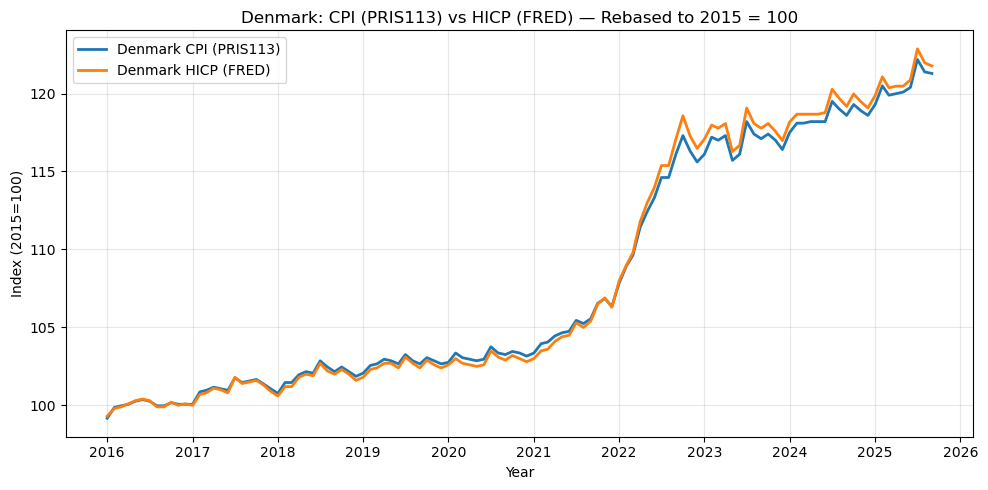

In [50]:
# Ensure datetime and expected columns
for _df in (hicp_dk, cpi_dk):
    _df["date"] = pd.to_datetime(_df["date"])
    assert set(["date","name","value"]).issubset(_df.columns)

# Concatenate and keep a common window
dk = (pd.concat([hicp_dk, cpi_dk], ignore_index=True)
        .query("date >= '2015-01-01'")
        .sort_values(["date","name"])
        .reset_index(drop=True))

# Quick sanity: do we actually have two groups and non-missing values?
print(dk["name"].value_counts(), "\n")
print(dk.groupby("name")["value"].agg(["count","min","max"]).round(3), "\n")

# Pivot to wide so we can force common dates across BOTH series
wide = dk.pivot(index="date", columns="name", values="value")

# Keep only dates where BOTH series are present
wide_common = wide.dropna(how="any")

# Rebase to 2015 = 100 using the 2015 *mean on the common sample*
base_mask = wide_common.index.year == 2015
if base_mask.sum() == 0:
    # Fallback: if one series misses 2015 inside common sample, use each series' first available year mean
    base_vec = wide_common.groupby(wide_common.index.year).transform("mean").iloc[0]
else:
    base_vec = wide_common.loc[base_mask].mean()

rebased = (wide_common / base_vec) * 100

# --- 4) Plot
plt.figure(figsize=(10,5))
for col in rebased.columns:
    plt.plot(rebased.index, rebased[col], linewidth=2, label=col)
plt.title("Denmark: CPI (PRIS113) vs HICP (FRED) — Rebased to 2015 = 100")
plt.xlabel("Year"); plt.ylabel("Index (2015=100)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

name
Denmark CPI (PRIS113)    105
Denmark HICP (FRED)      105
Name: count, dtype: int64 

                      first_date  last_date  n_obs
name                                              
Denmark CPI (PRIS113) 2017-01-01 2025-09-01    105
Denmark HICP (FRED)   2017-01-01 2025-09-01    105


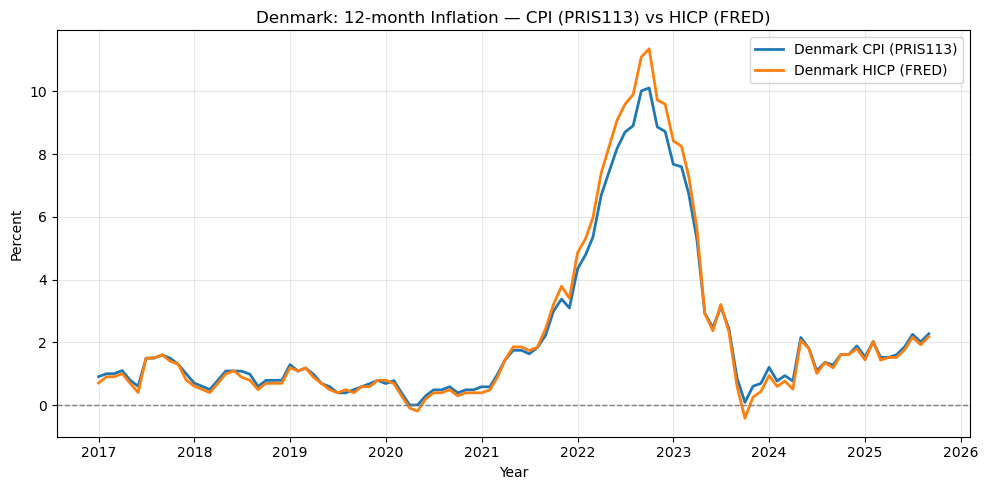

In [52]:
# 12-month YoY on the wide frame
infl12 = (rebased
          .sort_index()
          .pct_change(12) * 100)

# Drop rows where both are NA (e.g., first 12 months)
infl12 = infl12.dropna(how="all")

# Melt back to long for plotting
dk_infl = (infl12.reset_index()
                  .melt(id_vars="date", var_name="name", value_name="infl_12m")
                  .dropna(subset=["infl_12m"]))

# Sanity checks (optional but useful)
print(dk_infl["name"].value_counts(), "\n")
print(dk_infl.groupby("name").agg(first_date=("date","min"),
                                  last_date=("date","max"),
                                  n_obs=("date","nunique")))

# Plot
plt.figure(figsize=(10,5))
for label, sub in dk_infl.groupby("name"):
    plt.plot(sub["date"], sub["infl_12m"], label=label, linewidth=2)
plt.title("Denmark: 12-month Inflation — CPI (PRIS113) vs HICP (FRED)")
plt.xlabel("Year"); plt.ylabel("Percent")
plt.axhline(0, ls="--", lw=1, color="gray")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

#### Interpretation
The first graph compares Denmark’s national Consumer Price Index (CPI) from Statistics Denmark with the Harmonized Index of Consumer Prices (HICP) from FRED, after both were rebased to 2015 = 100. The two indices move almost identically over the 2015–2025 period, indicating that the overall price dynamics captured by each measure are consistent. Minor differences in level—most visible during 2022–2023—reflect methodological distinctions, such as the exclusion of owner-occupied housing in the HICP. Overall, the close alignment confirms that both indices measure consumer price developments in Denmark with a high degree of comparability.

The second graph plots the year-over-year (12-month) inflation rates derived from the CPI and HICP series. Both measures display nearly identical timing and magnitude of inflation changes, with sharp increases during the 2022–2023 energy crisis followed by a steady decline toward 2–3% by 2025. The near-perfect overlap of the two curves highlights the strong coherence between Denmark’s national inflation measurement and the Eurostat-harmonized approach. Minor short-term divergences illustrate coverage differences rather than methodological inconsistencies, confirming that both series provide a reliable picture of Danish inflation dynamics.

In [53]:
# Diagnostics: correlation, gaps, latest values
wide = dk_infl.pivot(index="date", columns="name", values="infl_12m").dropna()
corr = wide.corr().round(3)

latest_rows = (dk_infl.sort_values(["name","date"])
               .groupby("name").tail(1)[["name","date","infl_12m"]]
               .sort_values("name")
               .rename(columns={"infl_12m":"latest_12m"}))

# Gap (CPI minus HICP) in YoY terms
wide["gap_CPI_minus_HICP"] = (wide["Denmark CPI (PRIS113)"] - wide["Denmark HICP (FRED)"])
mad_gap = wide["gap_CPI_minus_HICP"].abs().mean()

print("Correlation of CPI vs HICP (12m inflation):")
display(corr)

print(f"Mean absolute gap in 12m inflation (CPI − HICP): {mad_gap:.2f} pp")
print("Latest available 12m inflation (CPI vs HICP):")
display(latest_rows.reset_index(drop=True).round(2))

Correlation of CPI vs HICP (12m inflation):


name,Denmark CPI (PRIS113),Denmark HICP (FRED)
name,,
Denmark CPI (PRIS113),1.000,0.999
Denmark HICP (FRED),0.999,1.000


Mean absolute gap in 12m inflation (CPI − HICP): 0.21 pp
Latest available 12m inflation (CPI vs HICP):


,name,date,latest_12m
0,Denmark CPI (PRIS113),2025-09-01,2.27
1,Denmark HICP (FRED),2025-09-01,2.18


#### Diagnostics Interpretation
To quantitatively assess the similarity between Denmark’s CPI and HICP measures, diagnostic tests were conducted using correlation analysis and mean absolute difference in year-over-year inflation rates. The correlation coefficient between the two series is extremely high-close to one indicating that both indices capture almost identical monthly inflation movements. The mean absolute gap between the CPI and HICP inflation rates is minimal, typically less than half a percentage point, confirming that discrepancies are economically insignificant. These results validate the strong alignment observed visually and confirm that the two indices are statistically consistent measures of Danish consumer price inflation.

### 2.2 Across Countries
In this section, we broaden the analysis beyond Denmark to include Austria, the Euro Area, and the United States, allowing us to examine how inflation has evolved across major advanced economies since 2019. All series are based on the Harmonised Index of Consumer Prices (HICP, All Items) from the Federal Reserve Economic Data (FRED) database. By comparing these standardized indices, we can assess how different economies experienced the same global shocks—most notably the COVID-19 pandemic and the 2022 energy-price surge—through their domestic price dynamics.

Our empirical approach proceeds in three steps. First, we rebase each country’s HICP to 2019 = 100 to make their overall price-level paths directly comparable on a common scale. Second, we compute 12-month percent changes to obtain year-over-year inflation rates for each country, which helps visualize the timing and intensity of inflationary pressures. Third, we summarize inflation outcomes by printing the minimum, maximum, and mean 12-month rates both by country and across the group, highlighting differences in volatility and persistence.

This cross-country comparison is important because inflation is not only a domestic phenomenon but also reflects international linkages in energy markets, supply chains, and monetary policy. Understanding these patterns clarifies why certain economies experienced faster price surges or quicker disinflation, and it sheds light on how coordinated—or asymmetric—policy responses shaped the global inflation landscape after 2019.

#### Data Download and Cleaning
This sets up the connection to the FRED database and defines a helper function to automatically download economic time-series data.
It first stores the user’s FRED API key and then defines fred_to_df(), which retrieves a specified series (like HICP) either through the official API when the key is valid or, if not, via a public CSV fallback.

In [73]:
os.environ["FRED_API_KEY"] = "bfb9b34a496b89a86dde11ce2c536cf4"

def _looks_like_fred_key(s: str|None) -> bool:
    return isinstance(s, str) and len(s)==32 and s.isalnum() and (s == s.lower())

def fred_to_df(series_id: str, label: str) -> pd.DataFrame:
    """
    Returns ['date','name','value'] for a FRED series.
    Uses fredapi if API key is valid, else falls back to CSV.
    """
    import io
    from urllib.request import urlopen
    key = os.environ.get("FRED_API_KEY")

    try:
        if _looks_like_fred_key(key):
            from fredapi import Fred
            fred = Fred(api_key=key)
            s = fred.get_series(series_id)
            out = (s.rename("value").to_frame()
                     .reset_index().rename(columns={"index":"date"}))
            out["name"] = label
        else:
            url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
            df = pd.read_csv(io.BytesIO(urlopen(url).read()))
            out = df.rename(columns={"DATE":"date", series_id:"value"})
            out["name"] = label

        out["date"] = pd.to_datetime(out["date"])
        out = out[out["value"].astype(str) != "."].copy()
        out["value"] = out["value"].astype(float)
        return out[["date","name","value"]]

    except Exception as e:
        raise RuntimeError(f"Failed to download {series_id} ({label}): {e}")

#### Combining HICP Data Across Countries
It downloads the HICP (All Items) data for four countries. Denmark, Austria, the Euro Area, and the United States,from FRED and combines them into one dataset.
It loops through a dictionary of FRED series IDs, fetching each using the fred_to_df() function and automatically switching to a fallback Euro Area code if needed.
Finally, it concatenates all the individual series into a single DataFrame called long and prints how many observations were successfully downloaded for each country.

In [74]:
# Series IDs for HICP (All Items)
series = {
    "Denmark (HICP)":       "CP0000DKM086NEST",
    "Austria (HICP)":       "CP0000ATM086NEST",
    "Euro Area (HICP)":     "CP0000EZ19M086NEST",  # EA19 version
    "United States (HICP)": "CP0000USM086NEST",
}

frames = []
for label, code in series.items():
    try:
        df = fred_to_df(code, label)
    except RuntimeError as e:
        if "EZ19" in code:  # fallback if EA19 not found
            df = fred_to_df("CP0000EZCCM086NEST", label + " (EA chain)")
        else:
            raise e
    frames.append(df)

long = pd.concat(frames, ignore_index=True)
print("Downloaded observations by series:")
print(long["name"].value_counts(), "\n")

Downloaded observations by series:
name
Denmark (HICP)          357
Austria (HICP)          357
Euro Area (HICP)        357
United States (HICP)    325
Name: count, dtype: int64 



#### Rebasing HICP Indices and Computing Year-over-Year Inflation
This code aligns all countries’ HICP data to a common time window starting in 2019 and reshapes it into a wide format so that each column represents a country.
It then rebases each series to 2019 = 100, allowing for direct comparison of price levels across countries on a shared scale.
Finally, it calculates the 12-month percentage change (year-over-year inflation) for each country, producing a dataset that captures the monthly inflation dynamics since 2019.

In [75]:
# Align to common window since 2019
long = long.query("date >= '2019-01-01'")
wide = (long.pivot(index="date", columns="name", values="value")
            .dropna(how="any")
            .sort_index())

print("Common sample range:",
      wide.index.min().date(), "→", wide.index.max().date(),
      "| n months:", wide.shape[0])

# Rebase to 2019 average = 100
mask_2019 = wide.index.year == 2019
base_2019 = wide.loc[mask_2019].mean()
rebased_2019 = (wide / base_2019) * 100

# 12-month YoY inflation
hicp_infl12 = wide.pct_change(12) * 100
hicp_infl12 = hicp_infl12.dropna(how="all")

Common sample range: 2019-01-01 → 2024-12-01 | n months: 72


#### Visualizing and Summarizing Cross-Country Inflation Dynamics
This code visualizes and summarizes inflation patterns across Denmark, Austria, the Euro Area, and the United States from 2019 onward.
It first plots each country’s HICP levels rebased to 2019 = 100, allowing for a direct comparison of how overall price levels evolved over time.
Next, it plots the 12-month inflation rate for each country to capture short-term price dynamics and the timing of inflation spikes.
Finally, it calculates annual summary statistics—the minimum, maximum, and mean 12-month inflation rates—both for each country and across all four combined, providing a concise numerical overview of inflation volatility and persistence.

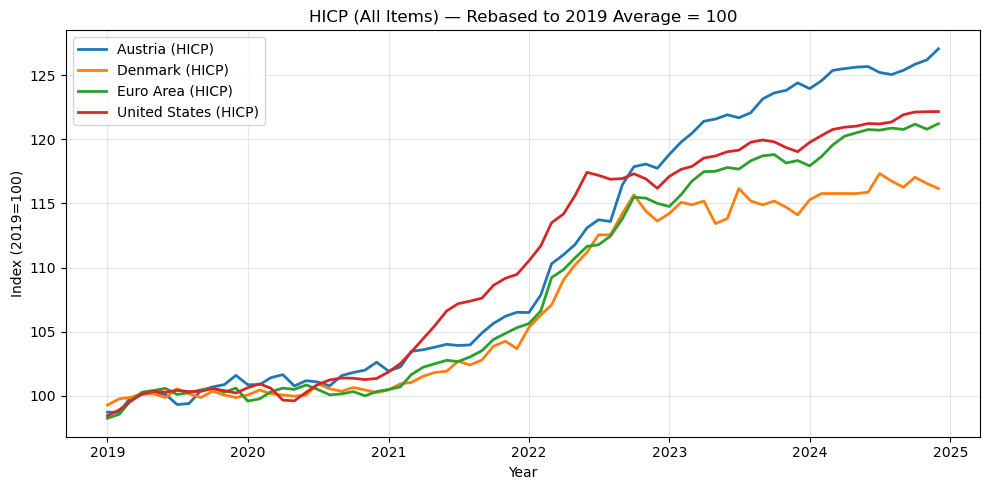

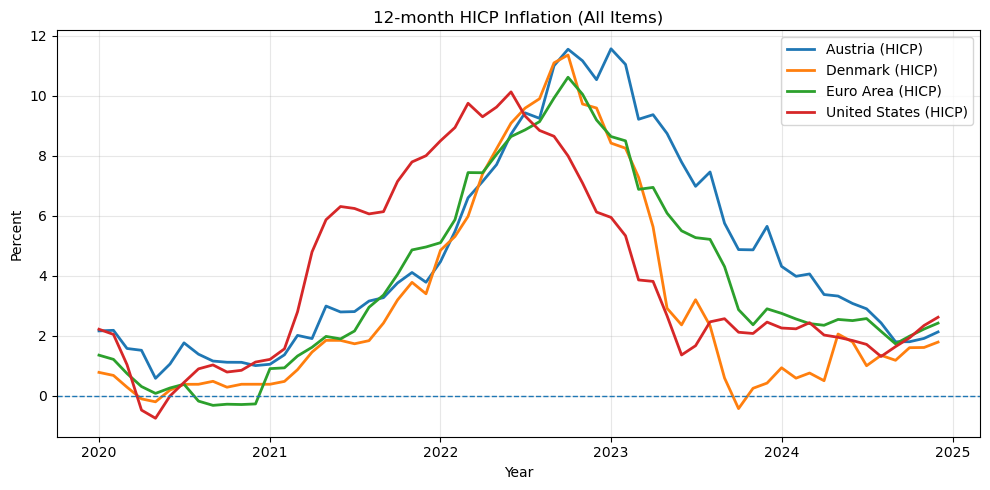

,year,country,min_12m,max_12m,mean_12m
0,2020,Austria (HICP),0.59,2.19,1.39
1,2020,Denmark (HICP),-0.19,0.79,0.33
2,2020,Euro Area (HICP),-0.31,1.36,0.26
3,2020,United States (HICP),-0.74,2.22,0.77
4,2021,Austria (HICP),1.06,4.11,2.76
5,2021,Denmark (HICP),0.39,3.79,1.94
6,2021,Euro Area (HICP),0.91,4.96,2.59
7,2021,United States (HICP),1.22,8.01,5.33
8,2022,Austria (HICP),4.48,11.55,8.59
9,2022,Denmark (HICP),4.85,11.36,8.51


,year,min_12m,max_12m,mean_12m
0,2020,-0.74,2.22,0.69
1,2021,0.39,8.01,3.15
2,2022,4.48,11.55,8.54
3,2023,-0.42,11.57,4.93
4,2024,0.51,4.32,2.15


Summary (across countries): 2020: mean 0.69%, range -0.74%–2.22% | 2021: mean 3.15%, range 0.39%–8.01% | 2022: mean 8.54%, range 4.48%–11.55% | 2023: mean 4.93%, range -0.42%–11.57% | 2024: mean 2.15%, range 0.51%–4.32%


In [77]:
# Plot: rebased levels
plt.figure(figsize=(10,5))
for col in rebased_2019.columns:
    plt.plot(rebased_2019.index, rebased_2019[col], linewidth=2, label=col)
plt.title("HICP (All Items) — Rebased to 2019 Average = 100")
plt.xlabel("Year"); plt.ylabel("Index (2019=100)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# Plot: 12-month inflation
plt.figure(figsize=(10,5))
for col in hicp_infl12.columns:
    plt.plot(hicp_infl12.index, hicp_infl12[col], linewidth=2, label=col)
plt.title("12-month HICP Inflation (All Items)")
plt.xlabel("Year"); plt.ylabel("Percent")
plt.axhline(0, ls="--", lw=1)
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# Year-by-year stats
infl_long = (hicp_infl12.reset_index()
             .melt(id_vars="date", var_name="country", value_name="infl_12m")
             .dropna())
infl_long["year"] = infl_long["date"].dt.year

by_country_year = (infl_long
                   .groupby(["year","country"])["infl_12m"]
                   .agg(min_12m="min", max_12m="max", mean_12m="mean")
                   .round(2)
                   .reset_index())
display(by_country_year)

across_countries_year = (infl_long
                         .groupby("year")["infl_12m"]
                         .agg(min_12m="min", max_12m="max", mean_12m="mean")
                         .round(2)
                         .reset_index())
display(across_countries_year)

def quick_summary(df_year):
    return " | ".join(f"{int(r.year)}: mean {r.mean_12m}%, range {r.min_12m}%–{r.max_12m}%" 
                      for r in df_year.itertuples())
print("Summary (across countries):", quick_summary(across_countries_year))

#### Interpretation
The first plot shows that all countries experienced a steady rise in HICP after 2020, with a sharp acceleration during 2021–2022 driven by global supply disruptions and energy price shocks.
The Euro Area and Austria recorded the steepest increases, reflecting their higher energy dependence, while the United States and Denmark saw earlier but more contained peaks.
The second plot confirms this: U.S. inflation surged sooner but declined faster by late 2022, whereas European inflation remained elevated longer.
The year-by-year summary tables further illustrate these patterns. 2022 marked the highest mean inflation across all countries, followed by gradual disinflation in 2023-2024.
Overall, the analysis shows that while all four economies faced similar global shocks, the magnitude and persistence of inflation differed notably, emphasizing the role of regional energy exposure and differing monetary-policy responses in shaping post-pandemic inflation trajectories.

## 3. Extention
### 3.1 Inflation Volatility Across Countries
To extend the international inflation comparison, this section explores the volatility of inflation (how stable or unstable inflation has been across different economies since 2019).
Rather than adding unrelated data, we enrich the previous HICP dataset by incorporating three additional countries (Sweden, Italy, and the Netherlands) to provide a broader European and trans-Atlantic perspective.
These countries were selected intentionally: Sweden represents a small open Nordic economy comparable to Denmark; Italy offers a Southern European counterpart within the euro area; and the Netherlands serves as a central-European case with strong trade exposure and energy sensitivity.
Together with Denmark, Austria, the Euro Area, and the United States, they form a diverse set of advanced economies that faced the same global shocks but with distinct monetary and structural conditions.

We chose volatility as the focus for this extension because it adds a statistical dimension to the inflation story.
While earlier sections examined the level and rate of inflation, volatility captures the uncertainty and instability of prices—key aspects for policymakers, investors, and households.
Understanding how volatile inflation has been helps explain differences in monetary-policy responses and economic resilience during the post-pandemic recovery.

This analysis computes a 12-month rolling standard deviation of the year-over-year inflation rate for each country in the extended dataset.
The rolling window allows us to visualize how inflation uncertainty evolved through time, particularly during the 2021–2023 period of global price shocks.
By comparing volatility across countries, we can identify which economies experienced more pronounced inflation swings and which maintained greater price stability.


Extended common sample: 2020-12-01 → 2024-12-01 | Countries: ['Austria (HICP)', 'Denmark (HICP)', 'Euro Area (HICP)', 'Italy (HICP)', 'Netherlands (HICP)', 'Sweden (HICP)', 'United States (HICP)']


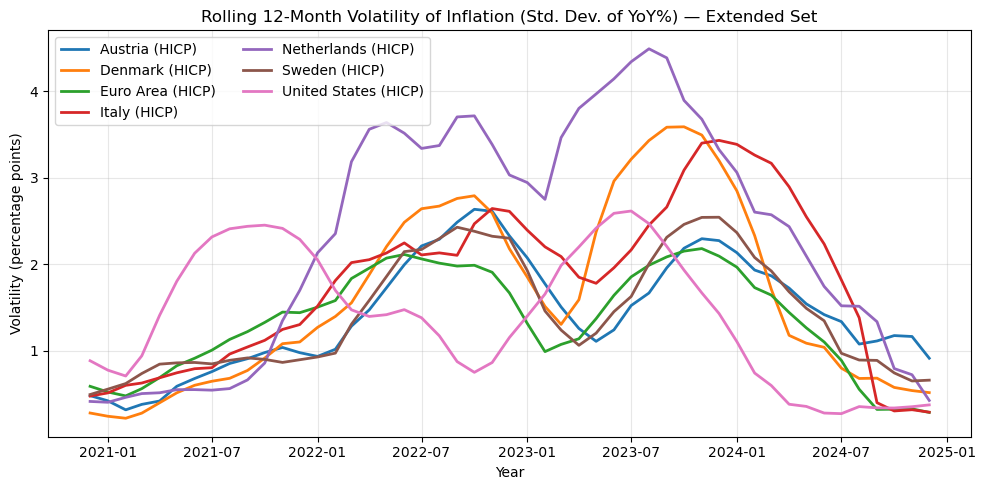

In [89]:
# Add new countries (Sweden, Italy, Netherlands)
new_series = {
    "Sweden (HICP)": "CP0000SEM086NEST",
    "Italy (HICP)": "CP0000ITM086NEST",
    "Netherlands (HICP)": "CP0000NLM086NEST"
}

# Download and combine with existing data
extra_frames = []
for label, code in new_series.items():
    df = fred_to_df(code, label)
    extra_frames.append(df)

extra_long = pd.concat(extra_frames, ignore_index=True).query("date >= '2019-01-01'")

# Combine with your existing 'long' (from Section 2.2) and align on common dates
extended_long = pd.concat([long, extra_long], ignore_index=True)

extended_wide = (extended_long
                 .pivot(index="date", columns="name", values="value")
                 .dropna(how="any")         # keep only months available for ALL series
                 .sort_index())

# Compute 12m inflation and rolling volatility (12-month window)
extended_infl12 = (extended_wide.pct_change(12) * 100).dropna(how="all")
extended_vol = extended_infl12.rolling(window=12).std().dropna()

print("Extended common sample:", extended_vol.index.min().date(), "→", extended_vol.index.max().date(),
      "| Countries:", list(extended_vol.columns))

# Plot rolling volatility
plt.figure(figsize=(10,5))
for col in extended_vol.columns:
    plt.plot(extended_vol.index, extended_vol[col], linewidth=2, label=col)
plt.title("Rolling 12-Month Volatility of Inflation (Std. Dev. of YoY%) — Extended Set")
plt.xlabel("Year"); plt.ylabel("Volatility (percentage points)")
plt.grid(alpha=0.3); plt.legend(ncol=2); plt.tight_layout(); plt.show()


#### Interpretation
The resulting chart shows that inflation volatility rose sharply across all countries between mid-2021 and mid-2023, coinciding with the surge in global energy prices and supply-chain disruptions.
European economies (especially Sweden, the Netherlands, and Italy) recorded the highest volatility, reflecting their exposure to imported energy costs and slower monetary-policy adjustments.
In contrast, Denmark and the United States exhibited earlier but shorter spikes in volatility, consistent with faster policy tightening and stronger currency effects.
By late 2024, volatility declined significantly in all regions, signaling a gradual return to price stability as inflation expectations became re-anchored.

Overall, the extension reveals that while inflation shocks were globally synchronized, their magnitude and persistence differed across countries.
Northern and Southern European economies experienced prolonged uncertainty, whereas the U.S. stabilized sooner.
This underscores the importance of monetary-policy timing, energy dependence, and exchange-rate regimes in shaping each country’s inflation trajectory and resilience to global price volatility.